 # Генерация цитат (англ.яз.) и коротких предложений "Войны и мир" (рус.яз.) 
 # Стэк: Pytorch (RNN, GRU, LSTM)
 ### *Вычисления проводились на Google Colab*

 В ноутбуке рассмотрены способы обучения RNN, GRU, LSTM прогнозировать следующий символ на основании предшествующих. 

Обучение моделей проводится на датасетах, предоставленных командой курса Samsung, а именно "Quotes" и "Война и мир"

RNN в ноутбуке реализовано в двух способах:
* хэнд-мэйд RNN
* RNN из пакета Pytorch

После обучения моделей мы сгенерируем несколько предложений и посмотрим как модель научилась предсказывать символы, оценим насколько близко наша модель к естественному языку

Основная задача - понять механику RNN и научиться использовать реккурентные сети в задачах NLP

В целях компактности исследования, на каждом датасете мы обучим только по одной LSTM модели. Проводить сравнение качества RNN с GRU и LSTM в этом ноутбуке мы не будем.

*По мотивам [семинара](https://github.com/Samsung-IT-Academy/stepik-dl-nlp/blob/master/task4_RNN_name_generator.ipynb)
 курса ["Нейронные сети и обработка текста (Samsung)"](https://stepik.org/lesson/262247/step/1?unit=243130)*

**Подключимся к хранилищу Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Импортируем все необходимые библиотеки**

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 289 (delta 10), reused 14 (delta 6), pack-reused 266
Receiving objects: 100% (289/289), 42.27 MiB | 22.85 MiB/s, done.
Resolving deltas: 100% (139/139), done.
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 1.7MB 39.1MB/s 
     |████████████████████████████████| 24.2MB 125kB/s 
     |████████████████████████████████| 307kB 55.2MB/s 
     |████████████████████████████████| 8.2MB 47.3MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=1d98d79e648c4d11e8d86963500da7cbe0c707389eaa9b4208f49d539d1a7eb3
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp36-cp36m-linux_x86_64.whl size=5625271 sha256=1b6f52bc1abbaeff12f472

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from IPython.display import clear_output
from random import sample

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from dlnlputils.pipeline import copy_data_to_device

from prettytable import PrettyTable

**Используемые функции и классы**

In [4]:
# преобразуем текст в числа для подачи данных в нейронную сеть

def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

**Напишем "своими руками" RNN и подходяший генератор текста**

In [5]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=52, embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [6]:
# функция для оценки параметров модели

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [7]:
# функция для исполнения петли - RNN loop

def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [8]:
# функция для генерации текста с возможностью регулировать вероятность появления символа в тексте - температура

def generate_sample_handmadeRNN(char_rnn, tokens, seed_phrase=' ', max_length=21, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    print (x_sequence.size(),x_sequence)
    hid_state = char_rnn.initial_state(batch_size=1)
    print (hid_state.size())
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

**Воспользуемся RNN из пакета Pytorch и напишем подходяший генератор текста**

In [9]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=52, maxlensent=21, emb_size=16, rnn_num_units=64, num_layers=1):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
#         self.norm = nn.BatchNorm1d(maxlensent)
        self.rnn = nn.RNN(emb_size, rnn_num_units, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hid_state):
        # assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        x = self.emb(x)
#         x = self.norm(x)
        if hid_state is not None:
            h_seq, hid_state = self.rnn(x, hid_state)
        else:
            h_seq, hid_state = self.rnn(x)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hid_state


In [10]:
def generate_sample(model, tokens, seed_phrase=' ', max_length=21, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = None
#     hid_state = Variable(torch.zeros(1,1,4*26))
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        _, hid_state = model.forward(x_sequence[:, i].unsqueeze(0), hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
#         print (hid_state, )
        logp_next, hid_state = model.forward(x_sequence[:, -1].unsqueeze(0), hid_state)
#         print (hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

**GRU class**

In [11]:
class CharGRULoop(nn.Module):
    def __init__(self, num_tokens=52, maxlensent=21, emb_size=16, rnn_num_units=64, num_layers=1):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
#         self.norm = nn.BatchNorm1d(maxlensent)
        self.gru = nn.GRU(emb_size, rnn_num_units, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hid_state):
        # assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        x = self.emb(x)
#         x = self.norm(x)
        if hid_state is not None:
            h_seq, hid_state = self.gru(x, hid_state)
        else:
            h_seq, hid_state = self.gru(x)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hid_state


**LSTM class**

In [12]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=52, maxlensent=21, emb_size=16, rnn_num_units=64, num_layers=1):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
#         self.norm = nn.BatchNorm1d(maxlensent)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hid_state):
        # assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        x = self.emb(x)
#         x = self.norm(x)
        if hid_state is not None:
            h_seq, hid_state = self.lstm(x, hid_state)
        else:
            h_seq, hid_state = self.lstm(x)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hid_state


# **Поработаем с датасетом "Цитаты"**

 **Загрузим датасет и токенизируем его**

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('./stepik-dl-nlp/datasets/author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' ' + line for line in quotes]

In [ ]:
quotes[:5]

[' If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.',
 " Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.",
 ' Did you ever stop to think, and forget to start again?',
 ' Organizing is what you do before you do something, so that when you do it, it is not all mixed up.',
 ' Weeds are flowers too, once you get to know them.']

In [ ]:
print ('Количество лозунгов:', len(quotes))

Количество лозунгов: 36165


In [ ]:
# токенизируем датасет
tokens = list(set(''.join(quotes)))
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)

In [ ]:
print ('Количество символов:', num_tokens) 

Количество символов: 85


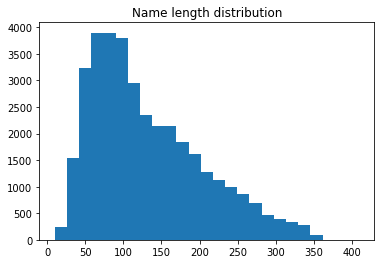

In [ ]:
# График распределения длины цитат
plt.title('Name length distribution')
plt.hist(list(map(len, quotes)), bins=25);

In [ ]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
print (token_to_id)

{'/': 0, 'F': 1, '(': 2, 'N': 3, 'h': 4, '"': 5, 'Q': 6, 'v': 7, 't': 8, 'c': 9, "'": 10, ';': 11, '7': 12, 'O': 13, 'Z': 14, ',': 15, 'u': 16, 'S': 17, '0': 18, '4': 19, ' ': 20, 'f': 21, 'C': 22, 'n': 23, '’': 24, 'k': 25, 'B': 26, '2': 27, 'E': 28, ':': 29, '?': 30, 'W': 31, '$': 32, '&': 33, 'd': 34, 'K': 35, 'A': 36, 's': 37, '.': 38, '#': 39, 'T': 40, 'J': 41, 'g': 42, 'G': 43, 'l': 44, '!': 45, ')': 46, 'P': 47, 'i': 48, 'm': 49, 'q': 50, '£': 51, 'I': 52, 'y': 53, '=': 54, 'b': 55, '6': 56, '—': 57, 'e': 58, 'a': 59, 'H': 60, 'D': 61, '5': 62, 'X': 63, 'z': 64, '8': 65, '*': 66, 'V': 67, 'U': 68, '3': 69, 'p': 70, 'r': 71, 'j': 72, 'o': 73, 'L': 74, 'Y': 75, '9': 76, '1': 77, '%': 78, 'w': 79, '-': 80, 'x': 81, '+': 82, 'M': 83, 'R': 84}


In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [ ]:
 ''' 
 ВНИМАНИЕ!!!

 Если нам требуется работать с предобученными моделями, то нам необходимо загрузить:
 - список токенов (символов) на которых происходило обучение
 - словарь токенов (символов) с ключами - значениями символов
 - параметры модели
 - историю обучения
Предварительно инициизировать модель
 '''

# # Сохраним список токенов (при необходимости)
# np.save('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/tokens_quotes.npy', tokens) 

# # Сохраним словарь (при необходимости)
# np.save('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/dict_quotes.npy', token_to_id) 

# Загрузим tokens
tokens = np.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/tokens_quotes.npy')
print(tokens)
print ()

# Загрузим dictionary
token_to_id = np.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/dict_quotes.npy',allow_pickle='TRUE').item()
print(token_to_id)

# Инициализируем модель
model = CharLSTMLoop(num_tokens=85, maxlensent=120, emb_size=30, rnn_num_units=119//5*30, num_layers=2)
opt = torch.optim.Adam(model.parameters())

# Загрузим параметры модели
model.load_state_dict(torch.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/quotes_LSTM_char_model.pth', 
                                                map_location=torch.device('cuda')))

# Загрузим историю
history = np.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/hist_learning_quotes.npy')
history = history.tolist()


 ''' 
 ВНИМАНИЕ!!!

                В случае если будет использоваться ранее предобученная модель, 
                то следующий блок в коде, где инициируется модель LSTM и запускается обучение,
                НЕОБХОДИМО ПРОПУСТИТЬ!!!
 '''

['I' 'W' 'S' '-' 'j' 't' 'Q' 'M' 's' '4' '(' '"' '8' 'E' 'H' '$' '1' 'Z'
 'u' 'e' '3' '5' '9' 'o' '7' 'g' 'z' 'D' 'R' 'f' 'V' 'b' ';' '’' 'k' 'i'
 ')' 'y' ':' '=' 'O' '&' '%' 'r' 'n' 'P' '.' '!' 'p' 'q' 'h' 'c' '£' 'v'
 '*' 'C' 'G' 'T' '0' 'w' 'a' 'Y' '#' '/' 'N' ' ' 'd' '6' 'U' '+' 'F' 'm'
 'x' ',' 'K' 'J' '—' 'l' "'" '2' 'B' 'A' 'L' 'X' '?']

{'I': 0, 'W': 1, 'S': 2, '-': 3, 'j': 4, 't': 5, 'Q': 6, 'M': 7, 's': 8, '4': 9, '(': 10, '"': 11, '8': 12, 'E': 13, 'H': 14, '$': 15, '1': 16, 'Z': 17, 'u': 18, 'e': 19, '3': 20, '5': 21, '9': 22, 'o': 23, '7': 24, 'g': 25, 'z': 26, 'D': 27, 'R': 28, 'f': 29, 'V': 30, 'b': 31, ';': 32, '’': 33, 'k': 34, 'i': 35, ')': 36, 'y': 37, ':': 38, '=': 39, 'O': 40, '&': 41, '%': 42, 'r': 43, 'n': 44, 'P': 45, '.': 46, '!': 47, 'p': 48, 'q': 49, 'h': 50, 'c': 51, '£': 52, 'v': 53, '*': 54, 'C': 55, 'G': 56, 'T': 57, '0': 58, 'w': 59, 'a': 60, 'Y': 61, '#': 62, '/': 63, 'N': 64, ' ': 65, 'd': 66, '6': 67, 'U': 68, '+': 69, 'F': 70, 'm': 71, 'x': 72, ',': 

' \nВНИМАНИЕ!!!\n\n               В случае если будет использоваться ранее предобученная модель, \n               то следующий блок в коде, где инициируется модель LSTM и запускается обучение,\n               НЕОБХОДИМО ПРОПУСТИТЬ!!!\n'

In [ ]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(quotes[::14000]))
print ()
print(to_matrix(quotes[::14000], token_to_id))
print ()
MAX_LENGTH = max(map(len, quotes))
print ('MAX_LENGTH:', MAX_LENGTH)

 If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.
 The best and most beautiful things in the world cannot be seen or even touched - they must be felt with the heart.
 Acting is a tough industry. There are a lot of kids out there at drama schools and not a lot of money about, especially as the arts are being cut.

[[65  0 29 65 37 23 18 65 77 35 53 19 65  5 23 65 31 19 65 60 65 50 18 44
  66 43 19 66 73 65  0 65 59 60 44  5 65  5 23 65 77 35 53 19 65  5 23 65
  31 19 65 60 65 50 18 44 66 43 19 66 65 71 35 44 18  8 65 23 44 19 65 66
  60 37 65  8 23 65  0 65 44 19 53 19 43 65 50 60 53 19 65  5 23 65 77 35
  53 19 65 59 35  5 50 23 18  5 65 37 23 18 46 65 65 65 65 65 65 65 65 65
  65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65
  65 65 65]
 [65 57 50 19 65 31 19  8  5 65 60 44 66 65 71 23  8  5 65 31 19 60 18  5
  35 29 18 77 65  5 50 35 44 25  8 65 35 44 65  5 50 19 65 59 23 43 77 66
  65 51 60 44 44 23

#### **Инициируем модель LSTM и запустим обучение**

In [ ]:
model = CharLSTMLoop(num_tokens=85, maxlensent=120, emb_size=30, rnn_num_units=119//5*30, num_layers=2)
opt = torch.optim.Adam(model.parameters())
history = []
print (model) 

CharLSTMLoop(
  (emb): Embedding(85, 30)
  (lstm): LSTM(30, 690, num_layers=2, batch_first=True)
  (hid_to_logits): Linear(in_features=690, out_features=85, bias=True)
)


In [ ]:
# # после 3500 проходов вручную понизили шаг
opt = torch.optim.Adam(model.parameters(), lr=0.001*0.5)
# # после 4100 проходов вручную понизили шаг
opt = torch.optim.Adam(model.parameters(), lr=0.001*0.2)

In [ ]:
count_parameters(model)

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
|      emb.weight      |    2550    |
|  lstm.weight_ih_l0   |   82800    |
|  lstm.weight_hh_l0   |  1904400   |
|   lstm.bias_ih_l0    |    2760    |
|   lstm.bias_hh_l0    |    2760    |
|  lstm.weight_ih_l1   |  1904400   |
|  lstm.weight_hh_l1   |  1904400   |
|   lstm.bias_ih_l1    |    2760    |
|   lstm.bias_hh_l1    |    2760    |
| hid_to_logits.weight |   58650    |
|  hid_to_logits.bias  |     85     |
+----------------------+------------+
Total Trainable Params: 5868325


5868325

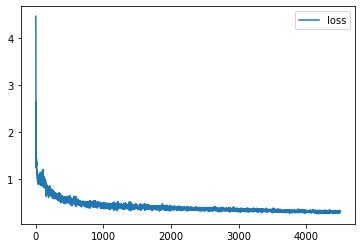

tensor(0.2945, device='cuda:0', grad_fn=<NegBackward>)


,loss
count,4500.000000
mean,0.409669
std,0.174561
min,0.253094
25%,0.324544
50%,0.363985
75%,0.426334
max,4.463945


In [ ]:
# до 2000 проходов батч использовался размером 64
# после 2000 проходов батч использовался размером 128
# Всего проходов: 4500

device = 'cuda'

if device == 'cuda':
  device = torch.device(device)
  model.to(device)

for i in range(400):
    batch_ix = to_matrix(sample(quotes, 128), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    batch_ix = copy_data_to_device(batch_ix, device)
    
    logp_seq, _ = model(batch_ix,hid_state=None)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()
        print (loss)

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

hist_df = pd.DataFrame(history,columns=['loss'])
hist_df['loss'] = hist_df['loss'].astype(float)
hist_df.describe()

#### **Проверим чему обучилась модель и сгенерируем несколько предложений**

In [ ]:
device = 'cpu'

if device == 'cpu':
  device = torch.device(device)
  model.to(device)

for _ in range(5):
    print(generate_sample(model, tokens, seed_phrase=' The men', max_length=MAX_LENGTH, temperature=0.65))

 The men who have come to believe they do not know himself.                                                                                                                                                                                                                                                                                                                                                              
 The men who invented the time would be to agree with failures. The kind of answer to God allows the capacity to forgive and the blood of disagreement.                                                                                                                                                                                                                                                                  
 The men of principing activities have been subject to security and art, neither but to which it is but a society for the companion of poverty.                                     

In [ ]:
device = 'cpu'

if device == 'cpu':
  device = torch.device(device)
  model.to(device)

for _ in range(5):
    print(generate_sample(model, tokens, seed_phrase=' ', max_length=MAX_LENGTH, temperature=0.6))

 I think we have to be recognized by the weather of the individual world.                                                                                                                                                                                                                                                                                                                                                
 I always like visitors and drama schools.                                                                                                                                                                                                                                                                                                                                                                               
 I love working the way dogs that I was doing for a long time. I often maintain that life in a miracle.                                                                             

####  **Сохраним параметры модели**

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/quotes_LSTM_char_model.pth')

In [ ]:
# Сохраним историю обучения (при необходимости)
np.save('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/hist_learning_quotes.npy', history) 

**Убедимся в том, что параметры модели сохранились правильно**

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/quotes_LSTM_char_model.pth', 
                                                map_location=torch.device('cuda')))

<All keys matched successfully>

In [ ]:
device = 'cpu'

if device == 'cpu':
  device = torch.device(device)
  model.to(device)

for _ in range(3):
    print(generate_sample(model, tokens, seed_phrase=' I', max_length=MAX_LENGTH, temperature=0.6))

 I always had a professional and a big open market. I've learned that the first time I pretty much look like that. Then I was a script wold through. I could have been the big brain flat.                                                                                                                                                                                                                               
 I can find out what it does to me is that I am a tough movie that loves a celebrity.                                                                                                                                                                                                                                                                                                                                    
 I like to look for anything that makes me happy personality.                                                                                                                       

# **Поработаем с датасетом "Война и мир"**

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('./stepik-dl-nlp/datasets/war_and_peace.txt') as input_file:
    war_peace = input_file.read()[:-1].split('\n')
    war_peace = [' ' + line for line in war_peace]

In [ ]:
war_peace[1000:1015]

['   - серьезно, я давно это думал. С этою жизнью я ничего не могу ни решить, ни',
 ' обдумать. Голова болит, денег нет. Нынче он меня звал, я не поеду.',
 '   - Дай мне честное слово, что ты не будешь ездить?',
 '   - Честное слово!',
 '   ',
 ' ',
 '                   IX.',
 ' ',
 '   ',
 '                   ',
 ' ',
 '     Уже был второй час ночи, когда Пьер вышел oт своего друга. Ночь была июньская,',
 ' петербургская, бессумрачная ночь. Пьер сел в извозчичью коляску с намерением',
 ' ехать домой. Но чем ближе он подъезжал, тем более он чувствовал невозможность',
 ' заснуть в эту ночь, походившую более на вечер или на утро. Далеко было видно по']

In [ ]:
MAX_LENGTH = max(map(len, war_peace))
print ('MAX_LENGTH:', MAX_LENGTH)

MAX_LENGTH: 85


In [ ]:
tokens = list(set(''.join(war_peace)))
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)
print ('Numbers of tokens:', num_tokens)

Numbers of tokens: 143


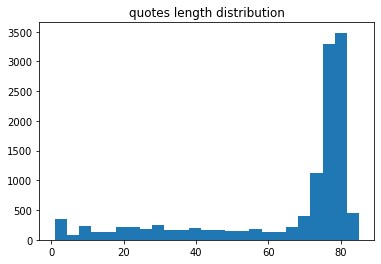

In [ ]:
plt.title('quotes length distribution')
plt.hist(list(map(len, war_peace)), bins=25);

In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [ ]:
 ''' 
 ВНИМАНИЕ!!!

 Если нам требуется работать с предобученными моделями, то нам необходимо загрузить:
 - список токенов (символов) на которых происходило обучение
 - словарь токенов (символов) с ключами - значениями символов
 - параметры модели
 - историю обучения
Предварительно инициизировать модель
 '''

# # Сохраним список токенов (при необходимости)
# np.save('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/tokens_war_peace.npy', tokens) 

# # Сохраним словарь (при необходимости)
# np.save('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/dict_war_peace.npy', token_to_id) 

# Загрузим tokens
tokens = np.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/tokens_war_peace.npy')
print(tokens)
print ()

# Загрузим dictionary
token_to_id = np.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/dict_war_peace.npy',allow_pickle='TRUE').item()
print(token_to_id)

# # Инициализируем модель
model = CharLSTMLoop(num_tokens=143, maxlensent=85, emb_size=42, rnn_num_units=115//5*28, num_layers=3)
opt = torch.optim.Adam(model.parameters())

# # Загрузим параметры модели
model.load_state_dict(torch.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/210215_war_peace_LSTM_char_model.pth', 
                                                map_location=torch.device('cuda')))

# # Загрузим историю
history = np.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/hist_learning_war_peace.npy')
history = history.tolist()


 ''' 
 ВНИМАНИЕ!!!

                В случае если будет использоваться ранее предобученная модель, 
                то следующий блок в коде, где инициируется модель LSTM и запускается обучение,
                НЕОБХОДИМО ПРОПУСТИТЬ!!!
 '''

['E' 'О' 'Д' 'з' '5' 'ч' 'P' 'o' 'e' 'Л' 'о' '"' '[' 'n' 'c' 'v' 'k' '('
 'Ш' 'F' 'Ф' 'a' 'Щ' 'G' 'Г' 'а' 'S' 'Э' ';' 'л' 'р' 'B' 'щ' 'Б' 'н' 'И'
 'V' 'э' 'П' 'D' 'ъ' 'u' ']' 'к' '*' 'j' 'Ю' '1' 'г' 'Й' 'b' 'L' 'M' 'Т'
 'в' '2' '0' 'у' 'К' 'й' 'U' 'Ц' 'М' 'д' 'T' 'r' 'ш' 'z' 'ё' '&' ',' 'y'
 's' '9' 'q' 'Х' 'ц' 'x' 'м' 'O' '8' '#' 'm' 'g' 'п' 't' 'Ч' 'W' 'Р' 'и'
 'с' 'Ь' 'З' 'w' 'Q' '!' 'A' 'Н' '?' '4' 'Z' ' ' ')' 'е' 'ф' '`' 'Ж' '/'
 'H' 'т' 'я' 'В' 'd' 'R' '7' ':' 'х' 'N' '.' 'С' 'Я' '6' 'h' 'А' '-' 'X'
 'Е' 'I' 'ю' 'C' 'K' 'l' 'i' 'J' 'ы' "'" 'У' 'б' '3' 'ж' 'p' 'ь' 'f']

{'E': 0, 'О': 1, 'Д': 2, 'з': 3, '5': 4, 'ч': 5, 'P': 6, 'o': 7, 'e': 8, 'Л': 9, 'о': 10, '"': 11, '[': 12, 'n': 13, 'c': 14, 'v': 15, 'k': 16, '(': 17, 'Ш': 18, 'F': 19, 'Ф': 20, 'a': 21, 'Щ': 22, 'G': 23, 'Г': 24, 'а': 25, 'S': 26, 'Э': 27, ';': 28, 'л': 29, 'р': 30, 'B': 31, 'щ': 32, 'Б': 33, 'н': 34, 'И': 35, 'V': 36, 'э': 37, 'П': 38, 'D': 39, 'ъ': 40, 'u': 41, ']': 42, 'к': 43, '*': 44, 'j': 45, 'Ю': 46, '1':

' \nВНИМАНИЕ!!!\n\n               В случае если будет использоваться ранее предобученная модель, \n               то следующий блок в коде, где инициируется модель LSTM и запускается обучение,\n               НЕОБХОДИМО ПРОПУСТИТЬ!!!\n'

#### **Инициируем модель LSTM и запустим обучение**

In [ ]:
model = CharLSTMLoop(num_tokens=143, maxlensent=85, emb_size=42, rnn_num_units=115//5*28, num_layers=3)
opt = torch.optim.Adam(model.parameters())
history = []
print (model)

CharLSTMLoop(
  (emb): Embedding(143, 42)
  (lstm): LSTM(42, 644, num_layers=3, batch_first=True)
  (hid_to_logits): Linear(in_features=644, out_features=143, bias=True)
)


In [ ]:
count_parameters(model)

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
|      emb.weight      |    6006    |
|  lstm.weight_ih_l0   |   108192   |
|  lstm.weight_hh_l0   |  1658944   |
|   lstm.bias_ih_l0    |    2576    |
|   lstm.bias_hh_l0    |    2576    |
|  lstm.weight_ih_l1   |  1658944   |
|  lstm.weight_hh_l1   |  1658944   |
|   lstm.bias_ih_l1    |    2576    |
|   lstm.bias_hh_l1    |    2576    |
|  lstm.weight_ih_l2   |  1658944   |
|  lstm.weight_hh_l2   |  1658944   |
|   lstm.bias_ih_l2    |    2576    |
|   lstm.bias_hh_l2    |    2576    |
| hid_to_logits.weight |   92092    |
|  hid_to_logits.bias  |    143     |
+----------------------+------------+
Total Trainable Params: 8516609


8516609

In [ ]:
# # после 5000 проходов вручную понизили шаг
opt = torch.optim.Adam(model.parameters(), lr=0.001*0.5)
# # после 4100 проходов вручную понизили шаг
# opt = torch.optim.Adam(model.parameters(), lr=0.001*0.2)

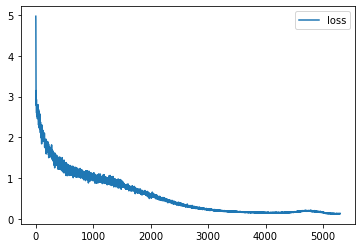

tensor(0.1336, device='cuda:0', grad_fn=<NegBackward>)


,loss
count,5300.000000
mean,0.574110
std,0.536365
min,0.121325
25%,0.169877
50%,0.314972
75%,0.912755
max,4.973409


In [ ]:
# ВНИМАНИЕ!!!
# до 1500 проходов подаешь батч размером 64
# после 1500 проходов размер батча увеличиваешь до 128
# Всего проходов: 5000

device = 'cuda'

if device == 'cuda':
  device = torch.device(device)
  model.to(device)

for i in range(100):
    batch_ix = to_matrix(sample(war_peace, 128), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    batch_ix = copy_data_to_device(batch_ix, device)
    
    logp_seq, _ = model(batch_ix,hid_state=None)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()
        print (loss)

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

hist_df = pd.DataFrame(history,columns=['loss'])
hist_df['loss'] = hist_df['loss'].astype(float)
hist_df.describe()

#### **Проверим чему обучилась модель и сгенерируем несколько предложений**

In [ ]:
device = 'cpu'

if device == 'cpu':
  device = torch.device(device)
  model.to(device)

for _ in range(15):
    print(generate_sample(model, tokens, seed_phrase=' ', max_length=MAX_LENGTH, temperature=0.55))

   - Вы не знаете Его, государь мой, и оттого вы очень несчастны. Вы не знаете       
 хотел понять, что вино нужно было ему не для того, чтобы утолить жажду, не из       
   - И в самом деле, - сказал Несвицкий. - Тут бы двух молодцов послать, всё         
 приготовился метать. Ростов покорно отогнул угол и вместо приготовленных 6 000,     
   - Как я увидал, ваше сиятельство, что первый батальон расстроен, я стал на        
   - Противоборствовать злу, царствующему в мире... - повторил Пьер, и ему           
   - Как я увидал, ваше сиятельство, что первый батальон расстроен, я стал на        
   - Да, в каких грустных обстоятельствах пришлось нам видеться, князь... Ну, что    
   - Когда жене будет время родить, пошлите в Москву за акушером... Чтоб он тут      
 поднялась в его душе, что он не только не мог спать, но не мог сидеть на месте и    
   - Ну, поди, поди с своим уродом! - сказала мать, притворно сердито отталкивая     
 подобно Маку под Ульмом, соединиться с войсками, шедш

In [ ]:
device = 'cpu'

if device == 'cpu':
  device = torch.device(device)
  model.to(device)

for _ in range(5):
    print(generate_sample(model, tokens, seed_phrase=' - Наташа?', max_length=MAX_LENGTH, temperature=0.5))

 - Наташа? - спросил он, и сердито отвечая на ее вопрос.                             
 - Наташа? - спросил он у Ростова.                                                   
 - Наташа? - спросил он, и для центраяя-ную улыбку, в одно и то же время было на     
 - Наташа? - сказал он, взяв Пьера за локоть; и в голосе его была так                
 - Наташа? - спросил он сам себя. - Я уже на счетел незаконный                       


#### **Сохраним параметры модели**

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/210215_war_peace_LSTM_char_model.pth')

In [ ]:
# Сохраним историю обучения (при необходимости)
np.save('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/hist_learning_war_peace.npy', history)

**Убедимся в том, что параметры модели сохранились правильно**

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/210215_war_peace_LSTM_char_model.pth', 
                                                map_location=torch.device('cuda')))

<All keys matched successfully>

In [ ]:
device = 'cpu'

if device == 'cpu':
  device = torch.device(device)
  model.to(device)

for _ in range(3):
    print(generate_sample(model, tokens, seed_phrase=' ', max_length=MAX_LENGTH, temperature=0.4))

   - Да ведь я сказал, что подличать не стану, - перебил Денисов и опять             
   - Ну давай спорить, - сказал князь Андрей. - Ты говоришь школы, - продолжал       
   - Последний раз говорю вам: обратите всё ваше внимание на самого себя, наложите   


# **Бонус - генеатор анекдотов :)**

 **Загрузим датасет и токенизируем его**

In [13]:
with open('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/anek.txt') as input_file:
    anek = input_file.read()[:-1].split('\n')
    anek = [' ' + line[:300] for line in anek]
    anek = [line.replace("\\n", " ") for line in anek]
    anek = [line.replace("\\\n", " ") for line in anek]
    anek = [line.replace("\\\\n", " ") for line in anek]

In [14]:
anek[:5]

[' Из учебника физики за 8 класс под ред. С.В. Громова. Задача N109. В озеро упала ветка. Пробегавший мимо олень успел заметить что волна созданная падением ветки дошла до берега за 10 с причем расстояние между соседними гребнями волн было равно 10 см и за 2 с было 4 всплеска о берег. Помогите оленю о',
 ' В школе учитель спрашивает ученика: - Когда умер Александр Македонский? - Умер? Я даже не знал что он болен! ',
 ' Урок в одной из владивостокских школ обсуждается волнующая тема любовь и брак. Вопрос ученицы: А зачем нужны светящиеся презервативы? Ответил ученик очень тихий и застенчивый: Они освещают путь! ',
 ' Папа спрашивает у Вовочки: - Вовочка, что читаешь? - Учительница дала почитать, называется - Лесбиянки! - Да ну?!! А ну, дай посмотреть... Берет книгу, разочарованно: - А-а-а... Лес Бианки! ',
 ' Ребятишки слепили снеговик. Девочка:  У него кое-чего не хватает. Мальчик:  Я знаю. Сейчас принесу. Девочка:  Неси две. Нос ему тоже из морковки сделаем.  ']

In [15]:
print ('Количество анекдотов:', len(anek))

Количество анекдотов: 130264


In [16]:
# токенизируем датасет
tokens = list(set(''.join(anek)))
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)

In [17]:
print ('Количество символов:', num_tokens) 

Количество символов: 211


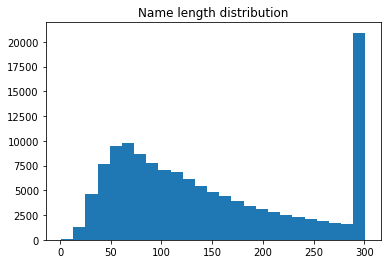

In [18]:
# График распределения длины цитат
plt.title('Name length distribution')
plt.hist(list(map(len, anek)), bins=25);

In [ ]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
print (token_to_id)

{'Т': 0, 'P': 1, 'т': 2, '“': 3, 'Ц': 4, '·': 5, '4': 6, 'H': 7, 'h': 8, 'Љ': 9, 'Е': 10, 'ы': 11, 'Ш': 12, 'О': 13, 'м': 14, '\xad': 15, 'Л': 16, 'Ч': 17, 'б': 18, 'a': 19, 'G': 20, '\x7f': 21, '@': 22, 'Э': 23, 'r': 24, 'ґ': 25, 'К': 26, '/': 27, '{': 28, '3': 29, 'k': 30, 'л': 31, '*': 32, 'З': 33, '\t': 34, '9': 35, 'd': 36, 't': 37, '|': 38, 'е': 39, '+': 40, 'x': 41, '¬': 42, 'й': 43, 'ї': 44, '(': 45, 'Ь': 46, 'A': 47, 'e': 48, '%': 49, 'ў': 50, 'q': 51, 's': 52, ' ': 53, '.': 54, 'n': 55, 'b': 56, '&': 57, 'Ќ': 58, 'ъ': 59, 'i': 60, 'M': 61, 'O': 62, '1': 63, '\x07': 64, '2': 65, '”': 66, 'S': 67, 'ђ': 68, 'с': 69, '#': 70, 'Р': 71, 'Ю': 72, 'ф': 73, 'J': 74, 'Й': 75, '~': 76, '¦': 77, '©': 78, 'ё': 79, 'Щ': 80, 'Ф': 81, 'щ': 82, '‡': 83, '0': 84, '„': 85, 'y': 86, 'V': 87, '=': 88, '§': 89, '}': 90, '±': 91, 'C': 92, '¶': 93, '\\': 94, '\x0f': 95, '«': 96, '†': 97, 'W': 98, 'm': 99, ';': 100, 'U': 101, 'Ж': 102, '[': 103, 'Ъ': 104, 'L': 105, 'у': 106, 'o': 107, 'И': 108, 'п': 

In [19]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [20]:
 ''' 
 ВНИМАНИЕ!!!

 Если нам требуется работать с предобученными моделями, то нам необходимо загрузить:
 - список токенов (символов) на которых происходило обучение
 - словарь токенов (символов) с ключами - значениями символов
 - параметры модели
 - историю обучения
Предварительно инициизировать модель
 '''

# # Сохраним список токенов (при необходимости)
# np.save('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/tokens_anek.npy', tokens) 

# # Сохраним словарь (при необходимости)
# np.save('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/dict_anek.npy', token_to_id) 

# Загрузим tokens
tokens = np.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/tokens_anek.npy')
print(tokens)
print ()

# Загрузим dictionary
token_to_id = np.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/dict_anek.npy',allow_pickle='TRUE').item()
print(token_to_id)

# Инициализируем модель
model = CharLSTMLoop(num_tokens=211, maxlensent=260, emb_size=78, rnn_num_units=260//15*78, num_layers=2)
opt = torch.optim.Adam(model.parameters())

# Загрузим параметры модели
model.load_state_dict(torch.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/anek_02_LSTM_char_model.pth', 
                                                map_location=torch.device('cuda')))

# Загрузим историю
history = np.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/hist_learning_anek_02.npy')
history = history.tolist()


 ''' 
 ВНИМАНИЕ!!!

                В случае если будет использоваться ранее предобученная модель, 
                то следующий блок в коде, где инициируется модель LSTM и запускается обучение,
                НЕОБХОДИМО ПРОПУСТИТЬ!!!
 '''

['›' '»' 'm' 'g' 'г' 'v' 'Х' 'ъ' '\x7f' 'Љ' 's' 'љ' ',' 'е' 'Ќ' 'к' 'a'
 'ш' '—' 'Ш' 'w' '©' '‹' '\xa0' 'k' 'x' '0' 'і' 'P' '~' '®' 'Y' '“' 'Р'
 'Ё' 'Ј' '+' 'Ч' 'Ф' '$' 'Я' 'n' '2' 'i' 'K' 't' 'ї' 'ѓ' 'R' 'Б' '’' 'H'
 '{' 'C' 'ѕ' '\xad' '/' '±' 'o' '°' 'Ж' 'e' 'c' 'I' '7' '#' '<' 'Г' 'ь'
 'f' 'О' '¬' ')' ' ' 'A' 'б' 'Й' '}' 'Ѕ' 'ж' '–' 'И' '8' '-' '\\' '4' 'Э'
 'ф' "'" '‚' '3' '·' 'F' 'р' 'Є' 'T' 'є' 'І' '*' 'э' '…' 'з' 'Ў' 'X' 'd'
 '«' '™' '•' '\x07' 'н' '>' 'Ы' 'Е' 'А' 'У' '|' '1' 'D' '‡' 'Ї' 'п' 'S'
 'V' 'ч' 'ы' 'Ц' 'а' '6' '†' ']' 'E' 'ђ' 'С' '\x0f' 'p' '\t' 'й' '¶' '9'
 'Щ' 'ў' 'N' 'b' 'Н' '=' '?' 'ю' '%' 'ћ' 'о' 'W' 'ґ' 'r' '^' 'j' 'Ъ' 'Т'
 '@' 'м' 'З' '¦' 'и' 'д' '(' '_' 'J' '5' 'B' 'u' 'Л' '!' 'ё' 'с' 'L' 'Ю'
 'Д' 'т' 'M' 'М' 'U' '.' 'l' 'O' 'л' 'µ' 'y' 'Ь' ':' '&' ';' 'х' 'П' 'z'
 '§' '№' 'К' 'у' 'ц' '„' '[' 'в' 'Z' '”' 'Q' 'я' 'щ' '¤' 'q' 'G' 'В' 'h']

{'›': 0, '»': 1, 'm': 2, 'g': 3, 'г': 4, 'v': 5, 'Х': 6, 'ъ': 7, '\x7f': 8, 'Љ': 9, 's': 10, 'љ': 11, ',': 12, 'е': 13, 'Ќ': 

' \nВНИМАНИЕ!!!\n\n               В случае если будет использоваться ранее предобученная модель, \n               то следующий блок в коде, где инициируется модель LSTM и запускается обучение,\n               НЕОБХОДИМО ПРОПУСТИТЬ!!!\n'

In [ ]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(anek[::14000]))
print ()
print(to_matrix(anek[::14000], token_to_id))
print ()
MAX_LENGTH = max(map(len, anek))
print ('MAX_LENGTH:', MAX_LENGTH)

 Из учебника физики за 8 класс под ред. С.В. Громова. Задача N109. В озеро упала ветка. Пробегавший мимо олень успел заметить что волна созданная падением ветки дошла до берега за 10 с причем расстояние между соседними гребнями волн было равно 10 см и за 2 с было 4 всплеска о берег. Помогите оленю о
 - Откуда берутся резиновые женщины?- Они рождаются после резинового члена.
 -- Ребе, муж хочет со мной развестись! -- Почему? -- Говорит, что не может с такой уродиной жить. Раввин берет толстую книгу, долго листает ее, наконец поднимает голову, смотрит на женщину и говорит: -- Твой муж прав. 
 В кабинете за смежными столами сидят программер С++ (отлаживает чужой драйвер принтера чеков для кассы) и программер 1С. Программер 1C запускает отладку, и вот уже в тысячный раз звучит раздражающий скрежет и вылезает чек. Сисадмин (истерично): бл&яя как я уже ненавижу этот бл&дский девайс !!! Про
 А давайте расставим все точки над Ы !  
 Лотерея - наиболее точный способ учета количества оптимистов.

#### **Инициируем модель LSTM и запустим обучение**

In [47]:
model = CharLSTMLoop(num_tokens=211, maxlensent=260, emb_size=105, rnn_num_units=260//15*105, num_layers=2)
opt = torch.optim.Adam(model.parameters())
history = []
print (model) 

CharLSTMLoop(
  (emb): Embedding(211, 105)
  (lstm): LSTM(105, 1785, num_layers=2, batch_first=True)
  (hid_to_logits): Linear(in_features=1785, out_features=211, bias=True)
)


In [38]:
# # # после 500 проходов вручную понизили шаг
# opt = torch.optim.Adam(model.parameters(), lr=0.001*0.5)
# # # # после 2000 проходов вручную понизили шаг
# opt = torch.optim.Adam(model.parameters(), lr=0.001*0.1)

In [48]:
count_parameters(model)

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
|      emb.weight      |   22155    |
|  lstm.weight_ih_l0   |   749700   |
|  lstm.weight_hh_l0   |  12744900  |
|   lstm.bias_ih_l0    |    7140    |
|   lstm.bias_hh_l0    |    7140    |
|  lstm.weight_ih_l1   |  12744900  |
|  lstm.weight_hh_l1   |  12744900  |
|   lstm.bias_ih_l1    |    7140    |
|   lstm.bias_hh_l1    |    7140    |
| hid_to_logits.weight |   376635   |
|  hid_to_logits.bias  |    211     |
+----------------------+------------+
Total Trainable Params: 39411961


39411961

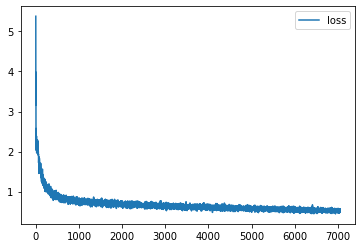

tensor(0.5056, device='cuda:0', grad_fn=<NegBackward>)


In [84]:
# # # после 500 проходов вручную понизили шаг
# opt = torch.optim.Adam(model.parameters(), lr=0.001*0.5)
# # # # после 2000 проходов вручную понизили шаг
# opt = torch.optim.Adam(model.parameters(), lr=0.001*0.1)
# #  после 1000 проходов изменил размер пакета с 64 на 256


device = 'cuda'

if device == 'cuda':
  device = torch.device(device)
  model.to(device)

for i in range(5):
    batch_ix = to_matrix(sample(anek, 128), token_to_id, max_len=301)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    batch_ix = copy_data_to_device(batch_ix, device)
    
    logp_seq, _ = model(batch_ix,hid_state=None)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.cpu().numpy())
    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()
        print (loss)


assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

hist_df = pd.DataFrame(history,columns=['loss'])
hist_df['loss'] = hist_df['loss'].astype(float)
hist_df.describe()

#### **Проверим чему обучилась модель и сгенерируем несколько предложений**

In [85]:
device = 'cpu'

if device == 'cpu':
  device = torch.device(device)
  model.to(device)

for _ in range(3):
    print(generate_sample(model, tokens, seed_phrase=' ', max_length=301, temperature=0.6))

  - Смотри, как подобает вам голова больного.   - Это все очень просто: я понимаю, что одна из них хочет жить в нем, но мне не мешай.                                                                                                                                                                        
  - Доктор, я умру, я бросаю в карман по голове своего брата!   - Ладно, но уже у меня нет никакой поля...                                                                                                                                                                                                   
  Мужик звонит в милицию:   - У меня вчера колготки по сотовому телефону разговаривали.   - Ну и что?   - Так ведь и музыканты не против.                                                                                                                                                                    


In [86]:
device = 'cpu'

if device == 'cpu':
  device = torch.device(device)
  model.to(device)

for _ in range(5):
    print(generate_sample(model, tokens, seed_phrase='  Муж', max_length=301, temperature=0.3))

  Мужик приходит к врачу и говорит:   - Доктор, у меня проблема: я всегда спрашиваю, что вы хотите.   - А вы пробовали выпить?   - Да, конечно, вот вы можете себе представить.   - Да я вам после свадьбы открой дверь - вы пришли домой и убили себя в руках!   - Ну и что?   - В этом месте я пришел с жен
  Мужик приходит к врачу.   - Доктор, у меня проблема: я выпил со стола попугая.   - Вам какой?   - Да еще и в прошлый раз продал ваш водолаз.                                                                                                                                                               
  Мужик приходит к сексопатологу.   - Доктор, я хочу продать молодого человека.   - А вы пробовали спать с мужем?   - Ну, это не просто. Приходите к нам на своем начальнике с женой после того, как она полетит на столе.                                                                                   
  Мужик приходит к врачу.   - Доктор, а вы можете сделать мне ноги от моего мужа?   - Ничего с

####  **Сохраним параметры модели**

In [87]:
torch.save(model.state_dict(), '/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/anek_02_LSTM_char_model.pth')

In [88]:
# Сохраним историю обучения (при необходимости)
np.save('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/hist_learning_anek_02.npy', history) 

**Убедимся в том, что параметры модели сохранились правильно**

In [89]:
model.load_state_dict(torch.load('/content/drive/My Drive/ds_projects/samsung_dlnlp/04_module_rnn/anek_02_LSTM_char_model.pth', 
                                                map_location=torch.device('cuda')))

<All keys matched successfully>

In [78]:
device = 'cpu'

if device == 'cpu':
  device = torch.device(device)
  model.to(device)

for _ in range(3):
    print(generate_sample(model, tokens, seed_phrase=' ', max_length=301, temperature=0.3))

  Приходит мужик к врачу:   - Доктор, у меня не встает.   - Ну давайте поиграем.   - А что вы делаете?   - Да вот понимают, в продаже появились новые подруги.   - Ну и что?   - А вы попробуйте помочь мне на ночь с такими поздней дверью.                                                                 
  По статистике в России закончилась статья масса делать все до дома, но и он стал приставать к себе домой.                                                                                                                                                                                                  
 - Почему в России не хватает программистов? - Потому что в России все попадаются в дело -  на последний момент все повторяются.                                                                                                                                                                             


# **Вместо выводов**

В этом ноутбуке для компактности представления использовались только LSTM модели. 

В сравнении с GRU, RNN существенно заметной разницы между моделями не выявлено. 

*******************************************************************************
**??** Для задач генерации текста конечно же стоит воспользоваться готовым трансформером (BERT,ROBERTA, etc)
*******************************************************************************

С точки зрения апгрейда моделей на базе pytorch, можно использовать кодирование слова - **Byte Pair Encodin**

На что еще можно обратить внимание: 
 * проверить эффективность иных оптимизаторов (SGD),
 * эксперементировать со структурой и параметрами моделей,
 * регулировать шаг,
 * использовать нормализацию батча для ускорения сходимости. 

*Изначально задача стояла в том, чтобы разобраться в механизме рек.сетей и обучить модели генерировать более менее осмысленный текст.*

*В первом приближении с задачей справились :)*

*По мотивам [семинара](https://github.com/Samsung-IT-Academy/stepik-dl-nlp/blob/master/task4_RNN_name_generator.ipynb)
 курса ["Нейронные сети и обработка текста (Samsung)"](https://stepik.org/lesson/262247/step/1?unit=243130)*